In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [25]:
import unnet
from unnet.samplers import *
from unnet.pipeline import *
from unnet.generators import *
from unnet.visualize import *
from unnet.centralities import *


In [26]:
from unnet.RealDataSets import *
from unnet.generators import ParamsSetter
#from unnet.pipeline import ParamsSetter
class RealDatasetLoader(ParamsSetter):
    def __init__(self):
        self.name = None
        self.use_cache=True
        self.cache = {}
        self.use_connected_component = True
    
    @property
    def parameters_mapping(self):
        return {'name' : 'name',}
    
    def execute(self,):
        if self.use_cache==True:
            if self.name in self.cache:
                return self.cache[self.name]
        G = self.load()
        if self.use_cache:
            self.cache[self.name] = G
        return G
    def load(self):
        
        if self.name=='brazil':
            G = load_brazil_dataset()
        
        if self.name=='pok':
            G =  load_pok_dataset()
        
        if self.name=='aps':
            G =  load_aps_dataset()
        
        if self.name=='github':
            G =  load_github_dataset()
        
        if self.name=='dblp':
            G =  load_dblp_dataset()
        if self.use_connected_component:
            import graph_tool as gt
            import graph_tool.topology as topo
            labels = topo.label_largest_component(G)
            G = gt.Graph(gt.GraphView(G, vfilt = labels), prune=True)
        return G

In [58]:
repetitions=10

show_std=True
mode="unsafe"


names = [ 'brazil','pok', 'github', 'dblp', 'aps']


generator = ParametersZip(RealDatasetLoader(),
                          {'name': names})
print(show_std)

True


In [28]:
all_measures = ["degree"]#, "katz", "pagerank"]

In [29]:
tmp= []
minlength=10000
if "degree" in all_measures:
    tmp.append(DegreeByClass(["distr","distr_cumsum", "top_places"], minlength=minlength))
if "katz" in all_measures:
    tmp.append(KatzByClass(["distr_cumsum", "top_places"], minlength=minlength))
if "pagerank" in all_measures:
    tmp.append(PagerankByClass(["distr_cumsum", "top_places"], minlength=minlength))
    

measures=JoinMeasures([*tmp,
    MinorityFraction(),
   EdgeCountByClass(['raw'])
#    BetweennessByClass(["distr_cumsum"]),
#    EigenvectorByClass(["distr_cumsum"], max_iter=1000, epsilon=1e-5),
])

In [30]:
sampling_rates=[0.1, 0.3, 0.5, 0.7, 0.9]
sampler1 = ParametersZip(EdgeSampler(), {'desired_fraction' : sampling_rates})
result1=GraphPipeline(generator, measures, sampler=sampler1).execute(repetitions=repetitions)

In [31]:
retain_fac = [0.1,0.3,0.5,0.7,0.9,1]
def plot_result(result, show_std=False, groupby=['retain_factor'], invert=False):
    for measure in all_measures:
        print("<<<<<<<<", measure)
        if not invert:
            for value in np.unique(result[groupby[0]]):
                result_tmp=result[result[groupby[0]]==value]
                fig=plot_top_places(result_tmp, show_std=show_std, measure=measure, groupby=['homophily'])

                fig.suptitle(f"{measure}, retain={value}")
                display(fig)
        else:
            for h in np.unique(result.homophily):
                result_tmp=result[result.homophily==h]
                fig=plot_top_places(result_tmp, show_std=show_std, measure=measure, groupby=groupby)
                
                fig.suptitle(f"{measure}, h={h}")
                display(fig)
        plt.show()

In [32]:
def full_extent(ax, pad=0.0):
    from matplotlib.transforms import Bbox
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.xaxis.label, ax.yaxis.label]
    #items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [33]:

    #ax.set_aspect('equal')

In [34]:
def to_alpha(alpha, values):
    return values ** alpha
def inv_to_alpha(alpha, values):
    return (1-values) ** alpha

def inv_log_agg_function(cent1, cent2):
    """aggregates two centrality measures using logarithms and min_max_scaling
    
    """
    return 1-log_agg_function(cent1, cent2)

def inv_log_agg_function_alpha(alpha, cent1, cent2):
    """ Allows additional scaling of log_agg_function with a parameter alpha
    to roughly get retain factors for BA use
    retain factor 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,  0.7, 0.8, 0.9
    alpha         1.7, 1.0, 0.7, 0.5, 0.4, 0.26, 0.2, 0.1, 0.015 """
    return inv_log_agg_function(cent1, cent2) ** alpha

In [35]:
# Inter
matrices = [np.array([[0.9,v],[v, 0.9]]) for v in [0.1,0.3,0.5,0.7,0.9,]]
sampler_m1 = ParametersZip(BiasedEdgeSampler(), {'retain_matrix' : matrices})
# Intra
matrices = [np.array([[v,0.9],[0.9, v]]) for v in [0.1,0.3,0.5,0.7,0.9]]
sampler_m2 = ParametersZip(BiasedEdgeSampler(), {'retain_matrix' : matrices})
# Majority
matrices = [np.array([[v,v],[v, 0.9]]) for v in [0.1,0.3,0.5,0.7,0.9]]
sampler_m3 = ParametersZip(BiasedEdgeSampler(), {'retain_matrix' : matrices})
# Minority
matrices = [np.array([[0.9,v],[v, v]]) for v in [0.1,0.3,0.5,0.7,0.9]]
sampler_m4 = ParametersZip(BiasedEdgeSampler(), {'retain_matrix' : matrices})
# Uniform
sampling_rates=[0.1, 0.3, 0.5, 0.7, 0.9]
sampler_uniform = ParametersZip(EdgeSampler(), {'desired_fraction' : sampling_rates})


alphas = [1.7, 1.0, 0.7, 0.5, 0.4, 0.26, 0.2, 0.1, 0.015]
# Jaccard
samp_jaccard = AdditionalParamWrapper(SimilarityEdgeSampler(), partial(change_function_params, to_alpha), "alpha")
sampler_jaccard = ParametersZip(samp_jaccard, {'sim_type':'jaccard', 'alpha' : alphas})

# inv Jaccard
inv_jaccard = AdditionalParamWrapper(SimilarityEdgeSampler(), partial(change_function_params, inv_to_alpha), "alpha")
sampler_inv_jaccard = ParametersZip(inv_jaccard, {'sim_type':'jaccard', 'alpha' : alphas})

# Structure
from functools import partial
struct_sampler = ParametersZip(StructureEdgeSampler(log_agg_function_alpha), {
    'centrality':CentralityCache(DegreeByClass(["distr_cumsum"])),
    'alpha' : alphas })

# inv Structure
from functools import partial
inv_struct_sampler = ParametersZip(StructureEdgeSampler(inv_log_agg_function_alpha), {
    'centrality':CentralityCache(DegreeByClass(["distr_cumsum"])),
    'alpha' : alphas })

l=[
    (sampler_m1, 'inter'),
    (sampler_m2, 'intra'),
    (sampler_m3, 'majority'),
    (sampler_m4, 'minority'),
    (sampler_uniform,'uniform'),
    (IdentitySampler(), 'no sampling'),
    (sampler_jaccard, 'jaccard'),
    (sampler_inv_jaccard, 'inv jaccard'),
    (struct_sampler, 'structure'),
    (inv_struct_sampler, 'inv structure')
]
if True:
    all_samplers = ChainSamplers([x[0] for x in l], names = [x[1] for x in l])
    result_all = GraphPipeline(generator, measures, sampler=all_samplers).execute(repetitions=10)

In [36]:
def plot_across_noise_strength(results, in_name, k, ax):
    prev_x=None
    for name, (result, key) in results.items():
        result=result[result['name']==in_name]
        #print(result)
        m_place=[]
        s_place=[]
        #print(name)
        #print(key)
        if name=="no sampling":
            #print("test")
            #print(result)
            #print(result[key])
            #print(key, value)
            #tmp = result[result[key]==value]
            places = tmp['degree_min_places'].apply(lambda v: v[k]/k)
            for _ in range(len(x)):
                m_place.append(np.mean(places))
                s_place.append(np.std(places))
        else:
            x=[]
            for value in np.unique(result[key]):
                if key=='alpha':
                    x.append(value)#alpha_map[value])
                else:
                    x.append(value)
                tmp = result[result[key]==value]
                places = tmp['degree_min_places'].apply(lambda v: v[k]/k)
                #print(places,np.std(places))
                m_place.append(np.mean(places))
                s_place.append(np.std(places))
            prev_x=x
            #print(x)
        #print(m_place, x)
        ax.errorbar(x, m_place, yerr=s_place, label=name)
    #plt.legend()
    
    #print(result['minority_measured'])
    ax.plot(prev_x, np.full(len(prev_x), result['minority_measured'].iloc[0]), color="k", linestyle='dashed')
    
    #plt.title(f"h={h}")
    ax.set_ylim([-0.05,1.05])
    #ax=plt.gca()
    #ax.set_aspect('equal')

In [37]:
result_all['rate']=result_all.retain_matrix.apply(np.min)

In [38]:
result_all.columns

Index(['name', 'retain_matrix', 'sampler_name', 'desired_fraction', 'sim_type',
       'alpha', 'centrality', 'degree_distr_maj', 'degree_distr_min',
       'degree_distr_cumsum_maj', 'degree_distr_cumsum_maj_x',
       'degree_distr_cumsum_min', 'degree_distr_cumsum_min_x',
       'degree_min_places', 'degree_maj_places', 'minority_measured',
       'edge_raw', 'run', 'rate'],
      dtype='object')

In [39]:
def plot_num_edges_outer(results, in_name, ax, relative=True, complete_results=None):
    
    for name, (result2, key) in results.items():
        if name =="no sampling":
            continue
        result=result2[result2['name']==in_name]
        #print(result)
        m_place=[]
        s_place=[]
        x=[]
        for value in np.unique(result[key]):
            if key=='alpha':
                x.append(value)#alpha_map[value])
            else:
                x.append(value)
            tmp = result[result[key]==value]
            edges = tmp['edge_raw'].apply(lambda x: x.sum())
            #print(edges)
            #print(places,np.std(places))
            
            m_place.append(np.mean(edges))
            s_place.append(np.std(edges))
        #print(m_place, x)
        if relative:
            tmp = results['no sampling'][0]
            #print(tmp)
            tmp = tmp[tmp['name']==in_name]['edge_raw']
            tmp = tmp.apply(lambda x: np.sum(x))
            #print(tmp)
            #print(result[result['sampler_name']=='no_sampler'])
            m_place=np.array(m_place)/(np.mean(tmp))
            s_place=np.array(s_place)/(np.mean(tmp))
        #print(s_place)
        ax.errorbar(x, m_place, yerr=s_place, label=name)
    #plt.legend()
    
    #plt.title(f"h={h}")
    ax.set_ylim([-0.05,1.05])
    #ax=plt.gca()

In [62]:
filetype="pdf"
show_insets=True

/home/felix/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/felix/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/felix/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/felix/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/felix/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/felix/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWa

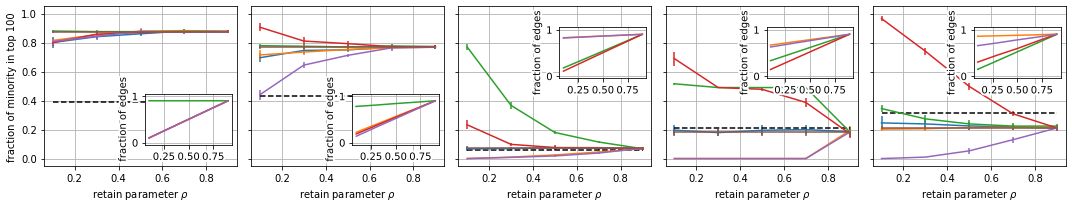

In [63]:

from matplotlib.transforms import IdentityTransform, TransformedBbox
def by_name(result_all, name):
    return result_all[result_all.sampler_name == name]

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
fig, axs = plt.subplots(1, len(names),figsize=(3*len(names), 3), sharey=True)
fig.set_tight_layout(True)
for ax, name in zip(axs, names):
    
    #ax1 = plt.subplots(1,len(hs),i+1, sharey=True)
    plot_across_noise_strength({
        'uniform' : (by_name(result_all,'uniform'), 'desired_fraction'),
#        'structure' : (result2,'alpha'),
        'inter' : (by_name(result_all,'inter'),'rate'),
        'intra' : (by_name(result_all,'intra'),'rate'),
        'majority' : (by_name(result_all,'majority'),'rate'),
        'minority' : (by_name(result_all,'minority'),'rate'),
        'no sampling' : (by_name(result_all,'no sampling'),'rate'),

#        'jaccard' : (result5, 'alpha')
    },
                               in_name=name,
                               k=100,
    ax=ax)
    ax.set_xlabel(r"retain parameter $\rho$")
    #ax.set_xlim([0.01,0.99])
    ax.grid(True)
axs[0].set_ylabel(f"fraction of minority in top {100}")
#axs[0].legend(fontsize=16)
#plt.show()
import matplotlib.patches as patches
axs2 = []
if len(axs) ==3:
    locs = [1,1,1]
else:
    locs = [4,4,1,1,1]
#locs = [1,1,1]#[4,4,1,1,1]
if show_insets:
    for ax,loc in zip(axs, locs):
        #ax.add_patch(patches.Rectangle((0.2,0.1),0.6,0.5, fc="red"))
        ax2 =  inset_axes(ax, width="50%", height="40%", loc=loc, bbox_to_anchor=(.1, .1, .9, 0.8),
                       bbox_transform=ax.transAxes,)
        axs2.append(ax2)


    for ax, name in zip(axs2, names):
        plot_num_edges_outer({
            'uniform' : (by_name(result_all,'inter'), 'desired_fraction'),
    #        'structure' : (result2,'alpha'),
            'inter' : (by_name(result_all,'inter'),'rate'),
            'intra' : (by_name(result_all,'intra'),'rate'),
            'majority' : (by_name(result_all,'majority'),'rate'),
            'minority' : (by_name(result_all,'minority'),'rate'),
            'no sampling' : (by_name(result_all,'no sampling'),'rate'),
    #        'jaccard' : (result5, 'alpha')
        },
       in_name=name,
        ax=ax)
        #ax.set_xlabel(r"retain parameter $\rho$")
        ax.set_ylabel(r"fraction of edges")
        ax.grid(True)
    
for ax2 in axs2:
    linewidth=4
    from matplotlib.patheffects import withStroke
    plt.setp(ax2.yaxis.get_majorticklabels(),
             path_effects=[withStroke(foreground="w", linewidth=4)])
    plt.setp(ax2.xaxis.get_majorticklabels(),
             path_effects=[withStroke(foreground="w", linewidth=4)])
    plt.setp(ax2.yaxis.get_label(),
             path_effects=[withStroke(foreground="w", linewidth=4)])

#axs[0].set_ylabel(f"number of edges")
#axs[0].legend(fontsize=16)
plt.show()


if True: # enable saving here
    for i,(ax, name) in enumerate(zip(axs, names)):
        box = ax.get_tightbbox(fig.canvas.get_renderer()).expanded(1.02,1).transformed(fig.dpi_scale_trans.inverted())
        #box = full_extent(ax,0.01).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f'real_retain_{name}.'+filetype, bbox_inches=box, dpi=300)
    
                            
                                    

(0.05, 0.05)


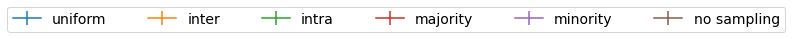

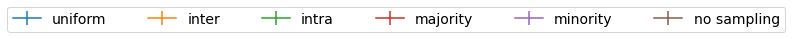

In [64]:
fig, legend_ax = plt.subplots(1, 1,figsize=(11, 0.5), sharey=True)
#fig.set_facecolor("black")
#fig.pad_inches(0)
fig.set_tight_layout(True)
#legend_ax.set_facecolor("black")
#legend_ax.set_ymargin(-0.1)
handles, labels = axs[0].get_legend_handles_labels()
legend_ax.axis('off')
print(legend_ax.margins())
#legend_ax.margins(y=0)
fontsize=14
fig.legend(handles, labels, loc='center', mode="expand", ncol=6,  fontsize=fontsize)
#legend_ax.set_autoscale(enable=True, tight=True)
display(fig)
fig.savefig(f'real_legend{fontsize}.'+filetype, dpi=300)


In [65]:
axs

array([<AxesSubplot:xlabel='retain parameter $\\rho$', ylabel='fraction of minority in top 100'>,
       <AxesSubplot:xlabel='retain parameter $\\rho$'>,
       <AxesSubplot:xlabel='retain parameter $\\rho$'>,
       <AxesSubplot:xlabel='retain parameter $\\rho$'>,
       <AxesSubplot:xlabel='retain parameter $\\rho$'>], dtype=object)

/home/felix/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


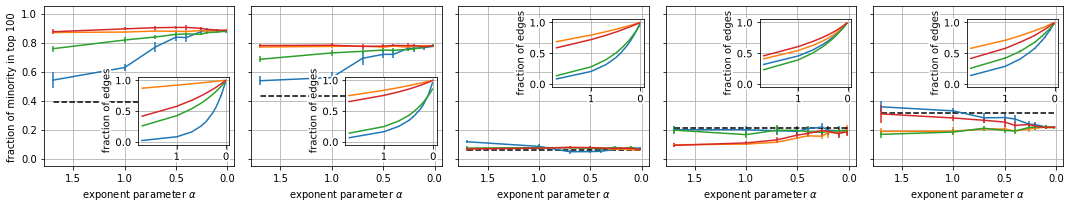

In [66]:

from matplotlib.transforms import IdentityTransform, TransformedBbox
def by_name(result_all, name):
    return result_all[result_all.sampler_name == name]
#hs = [0.25, 0.5,0.75]
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
fig, axs = plt.subplots(1, len(names),figsize=(3*len(names), 3), sharey=True)
fig.set_tight_layout(True)
for ax, name in zip(axs, names):
    
    #ax1 = plt.subplots(1,len(hs),i+1, sharey=True)
    plot_across_noise_strength({
        #'uniform' : (by_name(result_all,'uniform'), 'desired_fraction'),
#        'structure' : (result2,'alpha'),
        'jaccard' : (by_name(result_all,'jaccard'),'alpha'),
        'inv jaccard' : (by_name(result_all,'inv jaccard'),'alpha'),
        'structure' : (by_name(result_all, 'structure'),'alpha'),
        'inv structure' : (by_name(result_all, 'inv structure'),'alpha'),
        #'majority' : (by_name(result_all,'majority'),'rate'),
        #'minority' : (by_name(result_all,'minority'),'rate'),
        #'no sampling' : (by_name(result_all,'no sampling'),'no sampling'),
#        'jaccard' : (result5, 'alpha')
    },
                               in_name=name,
                               k=100,
    ax=ax)
    ax.set_xlabel(r"exponent parameter $\alpha$")
    ax.set_xlim((ax.get_xlim()[1], ax.get_xlim()[0]))
    #ax.set_xlim([0.01,0.99])
    ax.grid(True)
axs[0].set_ylabel(f"fraction of minority in top {100}")
#axs[0].legend(fontsize=16)
#plt.show()
import matplotlib.patches as patches
axs2 = []
locs = [4,4,1,1,1]
if show_insets:
    for ax,loc in zip(axs, locs):
        #ax.add_patch(patches.Rectangle((0.2,0.1),0.6,0.5, fc="red"))
        ax2 =  inset_axes(ax, width="60%", height="50%", loc=loc, bbox_to_anchor=(.2, .1, .8, 0.85),
                       bbox_transform=ax.transAxes,)
        axs2.append(ax2)


    for ax, name in zip(axs2, names):
        plot_num_edges_outer({
            #'uniform' : (by_name(result_all,'inter'), 'desired_fraction'),
    #        'structure' : (result2,'alpha'),
            'jaccard' : (by_name(result_all,'jaccard'),'alpha'),
            'inv jaccard' : (by_name(result_all,'inv jaccard'),'alpha'),
             'structure' : (by_name(result_all, 'structure'),'alpha'),
            'inv structure' : (by_name(result_all, 'inv structure'),'alpha'),
            'no sampling' : (by_name(result_all,'no sampling'),'no sampling'),
    #        'majority' : (by_name(result_all,'majority'),'rate'),
    #        'minority' : (by_name(result_all,'minority'),'rate'),
    #        'jaccard' : (result5, 'alpha')
        },
       in_name=name,
        ax=ax)
        #ax.set_xlabel(r"retain parameter $\rho$")
        ax.set_ylabel(r"fraction of edges")
        ax.set_xlim((ax.get_xlim()[1], ax.get_xlim()[0]))
        ax.grid(True)
    
for ax2 in axs2:
    linewidth=4
    from matplotlib.patheffects import withStroke
    plt.setp(ax2.yaxis.get_majorticklabels(),
             path_effects=[withStroke(foreground="w", linewidth=4)])
    plt.setp(ax2.xaxis.get_majorticklabels(),
             path_effects=[withStroke(foreground="w", linewidth=4)])
    plt.setp(ax2.yaxis.get_label(),
             path_effects=[withStroke(foreground="w", linewidth=4)])

#axs[0].set_ylabel(f"number of edges")
#axs[0].legend(fontsize=16)
plt.show()


if True: # enable saving here
    for i,(ax, name) in enumerate(zip(axs, names)):
        box = ax.get_tightbbox(fig.canvas.get_renderer()).expanded(1.02,1).transformed(fig.dpi_scale_trans.inverted())
        #box = full_extent(ax,0.01).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f'real_retain_alpha_{name}.'+filetype, bbox_inches=box, dpi=300)

(0.05, 0.05)


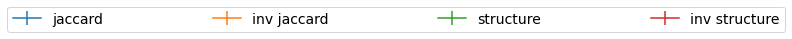

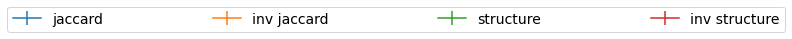

In [67]:
fig, legend_ax = plt.subplots(1, 1,figsize=(11, 0.5), sharey=True)
#fig.set_facecolor("black")
#fig.pad_inches(0)
fig.set_tight_layout(True)
#legend_ax.set_facecolor("black")
#legend_ax.set_ymargin(-0.1)
handles, labels = axs[0].get_legend_handles_labels()
legend_ax.axis('off')
print(legend_ax.margins())
#legend_ax.margins(y=0)
fontsize=14
fig.legend(handles, labels, loc='center', mode="expand", ncol=6,  fontsize=fontsize)
#legend_ax.set_autoscale(enable=True, tight=True)
display(fig)
fig.savefig(f'real_legend_struct{fontsize}.'+filetype, dpi=300)